In [1]:
import os

import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
# Save
def show_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis('off')

In [3]:
# Save
def show_grid(array, labels, n_rows=4, n_cols=10):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(array[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(labels[index], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [29]:
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [30]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [31]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

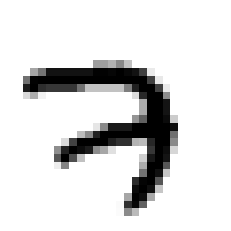

In [7]:
show_image(X_train[0])

In [8]:
show_image(X_train[0])

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

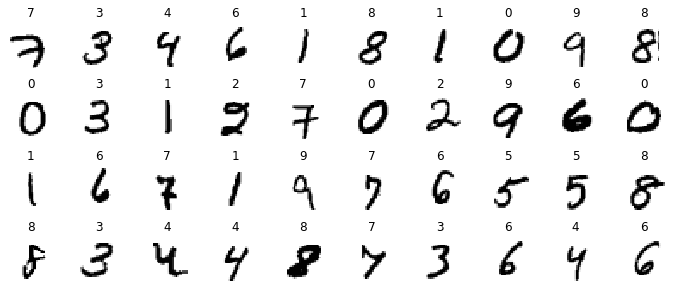

In [9]:
show_grid(X_train, y_train)

In [55]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        
    def plot_learning_rate(self):    
        plt.plot(self.rates, self.losses)
        plt.gca().set_xscale('log')
        plt.hlines(min(self.losses), min(self.rates), max(self.rates))
        plt.axis([min(self.rates), max(self.rates), 0, self.losses[0]])
        plt.xlabel("Learning rate")
        plt.ylabel("Loss");

In [51]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [14]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [15]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2344 - accuracy: 0.9271 - val_loss: 0.1006 - val_accuracy: 0.9698
Epoch 2/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0956 - accuracy: 0.9701 - val_loss: 0.0904 - val_accuracy: 0.9732
Epoch 3/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0614 - accuracy: 0.9808 - val_loss: 0.0926 - val_accuracy: 0.9728
Epoch 4/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0470 - accuracy: 0.9851 - val_loss: 0.0847 - val_accuracy: 0.9764
Epoch 5/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0799 - val_accuracy: 0.9786
Epoch 6/100
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0263 - accuracy: 0.9919 - val_loss: 0.0787 - val_accuracy: 0.9796
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.0782 - val_ac

In [16]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9826


[0.07063748687505722, 0.9825999736785889]

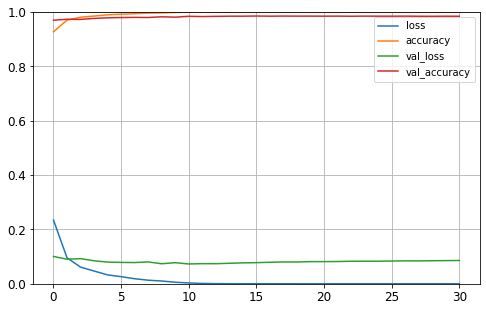

In [17]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1);

In [18]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0706 - accuracy: 0.9826


[0.07063748687505722, 0.9825999736785889]

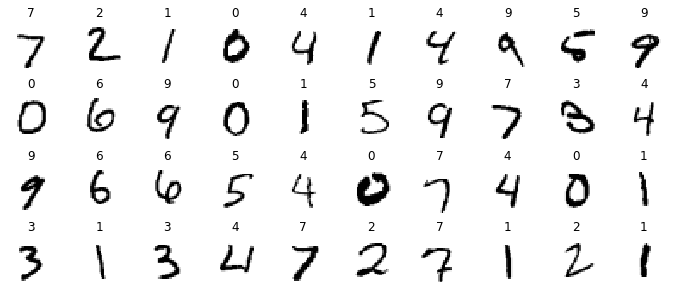

In [19]:
show_grid(X_test, y_test)

In [52]:
keras.backend.clear_session()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [53]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.6083 - val_loss: nan - val_accuracy: 0.0958


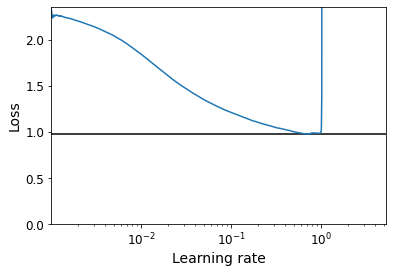

In [54]:
expon_lr.plot_learning_rate()

In [49]:
len(expon_lr.losses)

1719

In [ ]:
y